In [23]:
# Created on Sept 2022
# @author: matthieu.gilson@univ-amu.fr

# import libraries

# numpy and scipy
import numpy as np
import scipy.linalg as spl
import scipy.signal as spsg
import scipy.io as sio
import scipy.stats as stats

# MOU model
from test_MOU_largenet import MOUv2

# classification scikit-learn
import sklearn.linear_model as skllm
import sklearn.preprocessing as skppr
import sklearn.pipeline as skppl
import sklearn.neighbors as sklnn

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import pandas as pd


# Empirical data

In [ ]:
#IMPORTANT
pwd

'/home/angelica/Desktop/EntropyProduction_MOUProcess'

In [ ]:
data_dir = './' # data repo
res_dir = './' # results


graph_format = 'png' # graph formatting



conds = ['CTRL', 'SCZ']
n_cond = len(conds) # number of conditions

# 68 is the number of brain regions
N = 68 # size of network for DK-68 
# N = 20 # Frontal



## Structural data and masks

In [26]:
from enigmatoolbox.datasets import load_sc_as_one
from nilearn import plotting

sc_sctx, sc_sctx_labels = load_sc_as_one()

# Plot subcortico-cortical connectivity matrices
#sc_plot = plotting.plot_matrix(sc_sctx, figure=(9, 9), labels=sc_sctx_labels, vmax=10, vmin=0, cmap='Blues')

SC = sc_sctx[0:68,0:68]

In [27]:
# create topological mask for AAL90
#SC = sio.loadmat('/Users/rodrigo/Desktop/Postdoc-Codes/ENIGMA-master/sc_ctx.mat')['sc_ctx'] 
SC=SC/np.max(SC)
lim_SC = 0.6 # limit DTI value to determine SC (only connections with larger values are tuned)

# anatomy-derived mask for existing connections for EC
mask_ECS = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_ECS[SC>lim_SC] = True
for i in range(N):
    mask_ECS[i,i] = True # no self connection
    mask_ECS[i,N-1-i] = False # additional interhemispherical connections
print('network size:', N)
print('EC density:', mask_ECS.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (so far, tune noise matrix for diagonal elements only)
mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0


np.save(res_dir+'mask_ECS.npy',mask_ECS)
np.save(res_dir+'mask_Sigma.npy',mask_Sigma)


network size: 68
EC density: 0.16549604916593502


In [28]:
#SC = sio.loadmat('/Users/rodrigo/Desktop/Postdoc-Codes/ENIGMA-master/sc_ctx.mat')['sc_ctx'] 

In [29]:
#ts_scz.shape

In [30]:
ts_ctr = sio.loadmat('./ts_ctr.mat')['ts_ctr'] #./ = prendi il path
ts_ctr=ts_ctr[0:68,:,20:68]
ts_scz = sio.loadmat('./ts_scz.mat')['ts_scz']
ts_scz=ts_scz[0:68]
ts_all = np.stack((ts_ctr, ts_scz), axis=-1)

ts_all.shape


(68, 152, 48, 2)

In [31]:
ts_ctr.shape

(68, 152, 48)

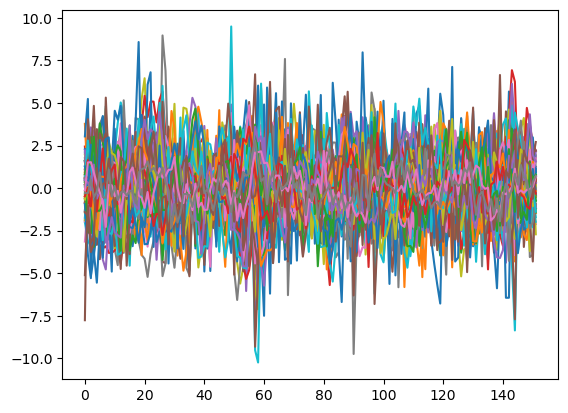

In [ ]:
#important brain signals -> capisci bene come cono fatti e come sono calcolate s(0) e s(1)
plt.plot(ts_all[:,:,18,1].T)

In [33]:
p1s=ts_all[:,:,18,1].T
p1s

array([[ 2.08930724,  0.76245141,  0.39690433, ..., -1.41024504,
        -0.13754258, -0.29317592],
       [-0.38785099,  0.73934484, -0.26493086, ..., -1.62191803,
         1.50767566, -0.2935976 ],
       [ 1.36370563, -0.92275061,  1.10197318, ..., -3.20329384,
         1.52265626,  0.5028249 ],
       ...,
       [ 0.94258266, -0.9903211 ,  0.93829087, ...,  1.39353338,
        -0.06859195, -0.51646604],
       [ 0.19361562,  0.55624975,  0.38580329, ..., -0.62801004,
         0.0789722 ,  0.34771849],
       [-0.12262438, -0.52350383, -1.19578338, ...,  0.62129889,
         0.67849041,  0.72904618]])

In [34]:
p1s=ts_all[:,:,18,1].T
p1s

array([[ 2.08930724,  0.76245141,  0.39690433, ..., -1.41024504,
        -0.13754258, -0.29317592],
       [-0.38785099,  0.73934484, -0.26493086, ..., -1.62191803,
         1.50767566, -0.2935976 ],
       [ 1.36370563, -0.92275061,  1.10197318, ..., -3.20329384,
         1.52265626,  0.5028249 ],
       ...,
       [ 0.94258266, -0.9903211 ,  0.93829087, ...,  1.39353338,
        -0.06859195, -0.51646604],
       [ 0.19361562,  0.55624975,  0.38580329, ..., -0.62801004,
         0.0789722 ,  0.34771849],
       [-0.12262438, -0.52350383, -1.19578338, ...,  0.62129889,
         0.67849041,  0.72904618]])

In [35]:
# BOLD broadband filtering
n_order = 2
TR = 2.0 # in seconds

Nyquist_freq = 0.5 / TR # Nyquist frequency
low_f = 0.001 / Nyquist_freq # lower cutoff for bandpass filter
high_f = 0.01  / Nyquist_freq # upper cutoff for bandpass filter
b,a = spsg.iirfilter(n_order,[low_f,high_f],btype='bandpass',ftype='butter')

# lags (in TR): 0 and 1
v_lag = np.arange(2,dtype=float)
n_lag = v_lag.size

# calc example FC for single subj
ts = sio.loadmat(data_dir+'ts_ctr.mat')['ts_ctr']
#ts = sio.loadmat('./ts_ctr.mat')['ts_ctr']
ts=ts[:, :,1]
filt_ts = spsg.filtfilt(b,a,ts,axis=1)
FC0 = np.tensordot(filt_ts[:,:-1], filt_ts[:,:-1], axes=(1,1)) / 150
FC1 = np.tensordot(filt_ts[:,:-1], filt_ts[:,1:], axes=(1,1)) / 150




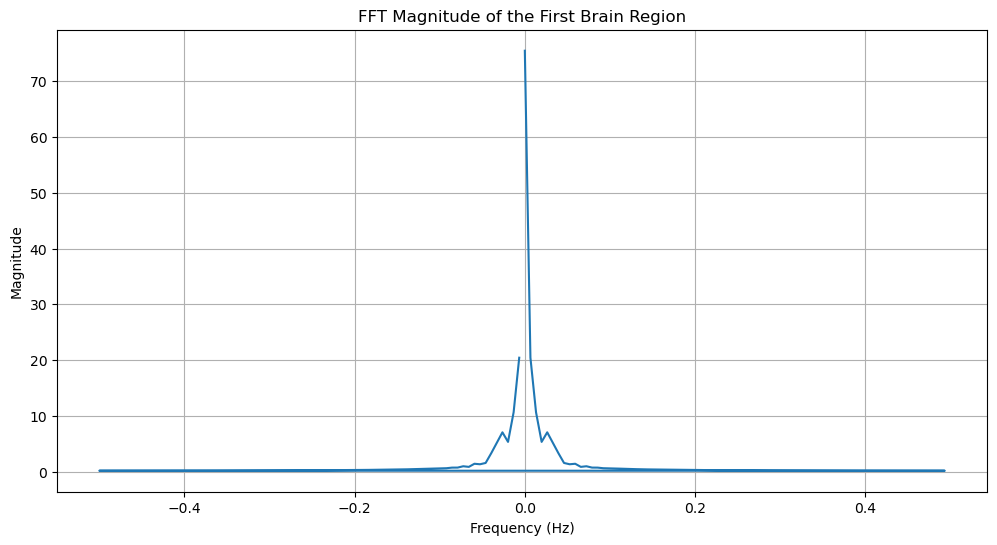

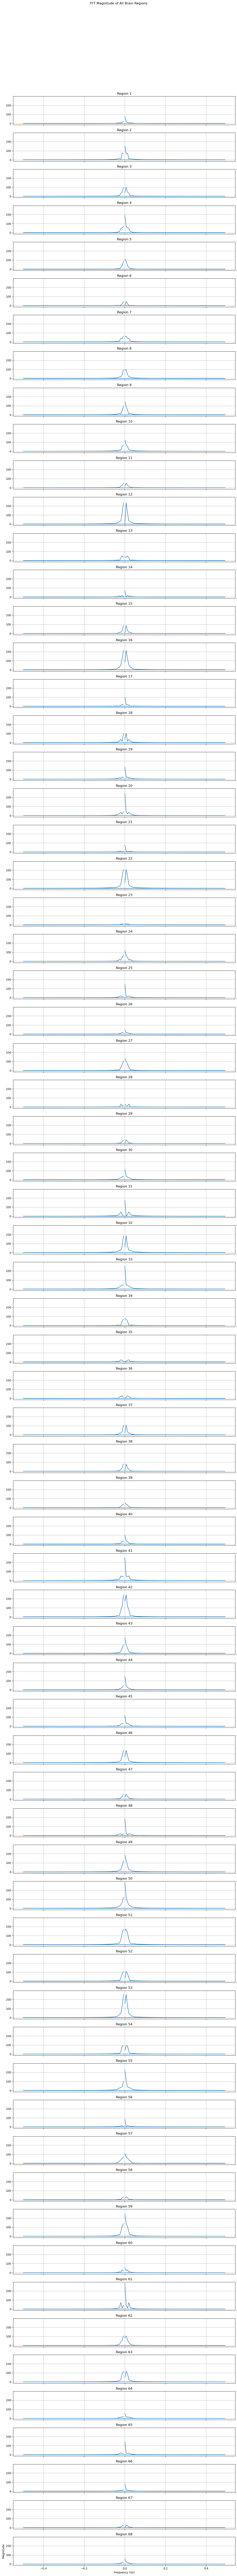

In [ ]:
#NON MI INTERESSA PERSONALMENTE MA È PER SCEGLIERE IL FILTERING

import numpy as np
import matplotlib.pyplot as plt

# Assuming your time series data is stored in a variable `time_series`
# with shape (68, 152). Here's how you might generate some example data:


# Perform FFT along the time dimension
fft_result = np.fft.fft(filt_ts, axis=1)

# To get the frequencies corresponding to the FFT results
frequencies = np.fft.fftfreq(filt_ts.shape[1])

# Compute the magnitude of the FFT
fft_magnitude = np.abs(fft_result)

# Plot the results for the first brain region as an example
plt.figure(figsize=(12, 6))
plt.plot(frequencies, fft_magnitude[0])
plt.title("FFT Magnitude of the First Brain Region")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

# Optionally, you can plot for all regions in subplots
fig, axs = plt.subplots(68, 1, figsize=(12, 2*68), sharex=True, sharey=True)
fig.suptitle('FFT Magnitude of All Brain Regions')

for i in range(68):
    axs[i].plot(frequencies, fft_magnitude[i])
    axs[i].set_title(f'Region {i+1}')
    axs[i].grid(True)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Visual test of data 

In particular for order of ROIs for 2 hemispheres...

In [ ]:
#PARTE DELLA MASK CHE NON MI INTERESSA PER I PRIMI TASK MA POTREBBE INTERESSARMI PER I SUCCESSIVI TASK CON LA CONNECTOME ANATOMICAL

# create topological mask for AAL90
#SC = sio.loadmat('/Users/rodrigo/Desktop/Postdoc-Codes/ENIGMA-master/sc_ctx.mat')['sc_ctx'] 
SC=SC/np.max(SC)
lim_SC = 0.0 # limit DTI value to determine SC (only connections with larger values are tuned)

# anatomy-derived mask for existing connections for EC
mask_ECS = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_ECS[SC>lim_SC] = True
for i in range(N):
    mask_ECS[i,i] = True # no self connection
    mask_ECS[i,N-1-i] = False # additional interhemispherical connections
print('network size:', N)
print('EC density:', mask_ECS.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (so far, tune noise matrix for diagonal elements only)
mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0


np.save(res_dir+'mask_ECS.npy',mask_ECS)
np.save(res_dir+'mask_Sigma.npy',mask_Sigma)

network size: 68
EC density: 0.31957857769973663


In [38]:
ts_all.shape

(68, 152, 48, 2)

In [ ]:
ts3=ts_all[0:68, :,18,0]
filt_ts = spsg.filtfilt(b,a,ts3,axis=1)
ts=stats.zscore(ts3, axis=1)
        
FC0 = np.tensordot(ts[:,:-1], ts[:,:-1], axes=(1,1)) / 149
FC1 = np.tensordot(ts[:,:-1], ts[:,1:], axes=(1,1)) / 149
FC0N=abs(FC0)/np.max(abs(FC0))
FC1N=abs(FC1)/np.max(abs(FC1))
        
lim_FC0= np.percentile(FC0N, 90)
lim_FC1= np.percentile(FC1N, 60)

# anatomy-derived mask for existing connections for EC
mask_EC1 = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_EC1[FC0N>lim_FC0] = True
for i in range(N):
    mask_EC1[i,i] = True # no self connection
    
mask_ECF= mask_EC1 

print('network size:', N)
print('EC density:', mask_ECF.sum()/float(N*(N-1)))

network size: 68
EC density: 0.10140474100087796


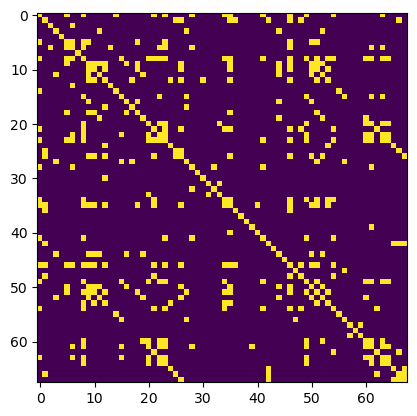

In [40]:
plt.imshow(mask_ECF)

In [41]:
lim_FC0

np.float64(0.4640972098162547)

# Model optimization

In [ ]:
#GRADIENT DESCENT PART. OPTIMIZATION OF GRADIENT DESCENT 
ts3.shape,ts_all.shape

((68, 152), (68, 152, 48, 2))

In [43]:

# data and model parameters
subjects = np.arange(1, 48)
n_sub = len(subjects)
N = 68

mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0
conds = ['CTR', 'SCZ']
n_cond = len(conds) # number of conditions

min_val_EC = 0. # maximal value for EC
max_val_EC = 1. # maximal value for EC
min_val_Sigma = 0. # minimal value for Sigma

# arrays to store results
var_BOLD = np.zeros([n_sub,n_cond,N]) # empirical BOLD variance
J_mod = np.zeros([n_sub,n_cond,N,N]) # model Jacobian (EC)
Sigma_mod = np.zeros([n_sub,n_cond,N,N]) # model 
FC0_mod = np.zeros([n_sub,n_cond,N,N]) # model zero-lad FC
err_mod = np.zeros([n_sub,n_cond]) # model error
fit_mod = np.zeros([n_sub,n_cond]) # model goodness of fit (Pearson corr)

#0.008-0.09 Hz
#0.008 to 0.08 Hz

n_order = 3
TR = 2 # in seconds
Nyquist_freq = 0.5 / TR # Nyquist frequency
low_f = 0.001 / Nyquist_freq # lower cutoff for bandpass filter
high_f = 0.01 / Nyquist_freq # upper cutoff for bandpass filter
b,a = spsg.iirfilter(n_order,[low_f,high_f],btype='bandpass',ftype='butter')


# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        # get time serie
        ts3=ts_all[0:68, :,i_sub,i_cond]
        filt_ts = spsg.filtfilt(b,a,ts3,axis=1)
        ts=stats.zscore(ts3, axis=1)
        
        # store empirical BOLD variance
        var_BOLD[i_sub,i_cond,:] = ts.var(axis=1)
        
        FC0 = np.tensordot(ts[:,:-1], ts[:,:-1], axes=(1,1)) / 149
        FC1 = np.tensordot(ts[:,:-1], ts[:,1:], axes=(1,1)) / 149
        FC0N=abs(FC0)/np.max(abs(FC0))
        FC1N=abs(FC1)/np.max(abs(FC1))
        
        lim_FC0= np.percentile(FC0N, 70)
        lim_FC1= np.percentile(FC1N, 60)

        # anatomy-derived mask for existing connections for EC
        mask_EC1 = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_EC1[FC0N>lim_FC0] = True
        for i in range(N):
            mask_EC1[i,i] = True # no self connection
            
        
        mask_EC2 = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_EC2[abs(FC1N)>lim_FC1] = True
        for i in range(N):
            mask_EC2[i,i] = False # no self connection
            
        mask_EC = np.zeros([N,N],dtype=bool)
        
        mask_EC=mask_EC1 
       # mask_EC=mask_ECS
        
        # invert model
        mou_est = MOUv2()
        mou_est.fit(ts.T, mask_C=mask_EC, mask_Sigma=mask_Sigma, algo_version='true', min_iter=100, epsilon_C=0.005, epsilon_Sigma=0.005) #, verbose=True)

        # store results
        J_mod[i_sub,i_cond,:,:] = mou_est.J
        Sigma_mod[i_sub,i_cond,:,:] = mou_est.Sigma
        FC0_mod[i_sub,i_cond,:,:] = spl.solve_lyapunov(J_mod[i_sub,i_cond,:,:].T, -Sigma_mod[i_sub,i_cond,:,:])
        err_mod[i_sub,i_cond] = mou_est.d_fit['distance']
        fit_mod[i_sub,i_cond] = mou_est.d_fit['correlation']

        print('sub', i_sub, '; cond', i_cond, ':', mou_est.d_fit)

#%% save results
np.save(res_dir+'J_mod.npy',J_mod)
np.save(res_dir+'Sigma_mod.npy',Sigma_mod)
np.save(res_dir+'FC0_mod.npy',FC0_mod)

np.save(res_dir+'err_mod.npy',err_mod)
np.save(res_dir+'fit_mod.npy',fit_mod)

np.save(res_dir+'var_BOLD.npy',var_BOLD)


sub 0 ; cond 0 : {'n_tau': 2, 'iterations': 115, 'distance': np.float64(0.8135047465385541), 'correlation': np.float64(0.6214308759747607), 'distance history': array([0.91124857, 0.90976858, 0.90830737, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.38559493, 0.39006185, 0.39446477, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.7714408135272603), 'distFC1': np.float64(0.8556536541910238)}
sub 0 ; cond 1 : {'n_tau': 2, 'iterations': 102, 'distance': np.float64(0.8570673277972392), 'correlation': np.float64(0.5798569610884972), 'distance history': array([0.91644941, 0.91293448, 0.90987062, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.37261965, 0.39888462, 0.42224516, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(3.5961182840794077), 'distFC1': np.float64(68.94547862611125)}
sub 1 ; cond 0 : {'n_tau': 2, 'iterations': 122, 'distance': np.float64(0.8412937154782556)

In [ ]:
#CERCA PERCHÈ NON TI TROVA QUESTO BOLD: NON HO QUESTA MATRICE NEI FILES
#PERCHÈ MI RIDEFINISCE n_cond, se lo metto nel codice mi crea problemi perche mi serve n_cond = 2


n_sub=15
n_cond=3
                        
ts2 = sio.loadmat(data_dir+'BOLD_timeseries_'+conds[i_cond]+'.mat')['BOLD_timeseries_'+conds[i_cond]][i_sub,0]
#ts2 = sio.loadmat('./BOLD_timeseries_'+conds[i_cond]+'.mat')['BOLD_timeseries_'+conds[i_cond]][i_sub,0]
ts3=ts2[:, :]
ts=stats.zscore(ts3, axis=1)
        
        # store empirical BOLD variance
var_BOLD[i_sub,i_cond,:] = ts.var(axis=1)
        
FC0 = np.tensordot(ts[:,:-1], ts[:,:-1], axes=(1,1)) / 249
FC1 = np.tensordot(ts[:,:-1], ts[:,1:], axes=(1,1)) / 249
FC0N=abs(FC0)/np.max(abs(FC0))
FC1N=abs(FC1)/np.max(abs(FC1))
        
lim_FC0= np.percentile(FC0N, 90)
lim_FC1= np.percentile(FC1N, 90)

mask_EC1 = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_EC1[FC0N>lim_FC0] = True
for i in range(N):
     mask_EC1[i,i] = False # no self connection
mask_EC2 = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_EC2[abs(FC1N)>lim_FC1] = True
for i in range(N):
    mask_EC2[i,i] = False # no self connection
mask_EC = np.zeros([N,N],dtype=bool)
mask_EC=mask_ECS+mask_EC1 


plt.figure(figsize=(5,4))
plt.imshow(np.array(mask_ECS, dtype=float), cmap='binary')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ROI index', fontsize=16)
plt.ylabel('ROI index', fontsize=16)
plt.tight_layout()

plt.figure(figsize=(5,4))
plt.imshow(np.array(mask_EC1, dtype=float), cmap='binary')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ROI index', fontsize=16)
plt.ylabel('ROI index', fontsize=16)
plt.tight_layout()


plt.figure(figsize=(5,4))
plt.imshow(np.array(mask_EC2, dtype=float), cmap='binary')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ROI index', fontsize=16)
plt.ylabel('ROI index', fontsize=16)
plt.tight_layout()

plt.figure(figsize=(5,4))
plt.imshow(np.array(mask_EC, dtype=float), cmap='binary')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ROI index', fontsize=16)
plt.ylabel('ROI index', fontsize=16)
plt.tight_layout()

plt.figure(figsize=(5,4))
plt.imshow(FC0, cmap='Blues')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ROI index', fontsize=16)
plt.ylabel('ROI index', fontsize=16)
plt.tight_layout()

plt.figure(figsize=(5,4))
plt.imshow(FC0_mod[n_sub,n_cond,:,:]/np.max(FC0_mod[n_sub,n_cond,:,:]), cmap='Blues')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ROI index', fontsize=16)
plt.ylabel('ROI index', fontsize=16)
plt.tight_layout()



FileNotFoundError: [Errno 2] No such file or directory: './BOLD_timeseries_SCZ.mat'

In [ ]:
np.max(FC0_mod[n_sub,n_cond,:,:])

In [ ]:
ve = FC0.flatten()
vs= FC0_mod[0,0,:,:].flatten()
np.corrcoef(ve,vs)
D=Sigma_mod[4,3,:,:]
D


## Check goodness of fit

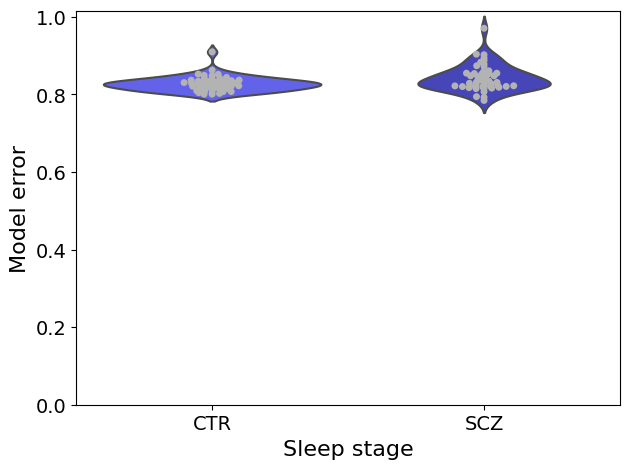

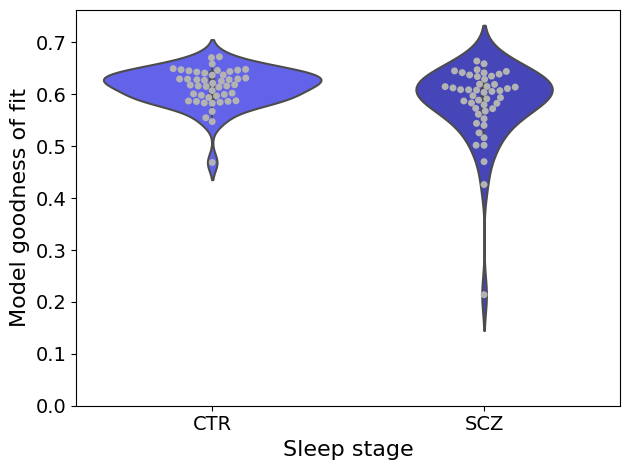

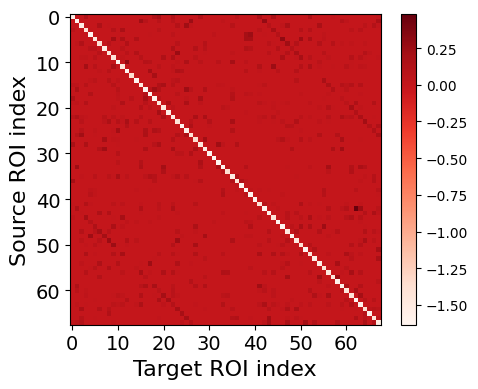

In [ ]:
#non mi interessa al momento, ma è per la goodness del fit

mask_diag = np.eye(N, dtype=bool) # mask for diagonal elements
n_cond=2

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]] # colors

# model error

err_mod_tmp = dict()
err_mod_tmp['sum EC'] = err_mod.flatten()
err_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
err_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

err_mod_df = pd.DataFrame(err_mod_tmp)

plt.figure()
sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=err_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Sleep stage',fontsize=16)
plt.ylabel('Model error',fontsize=16)

plt.tight_layout()
plt.savefig(res_dir+'model_fit_error.eps', format='eps')


# Pearson corr

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)

plt.figure()
sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=fit_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Sleep stage',fontsize=16)
plt.ylabel('Model goodness of fit',fontsize=16)

plt.tight_layout()
plt.savefig(res_dir+'model_goodness_fit.eps', format='eps')


# Example EC

plt.figure(figsize=(5,4))
#plt.imshow(np.maximum(J_mod[18,1,:,:],0), cmap='Reds')
plt.imshow(J_mod[18,1,:,:], cmap='Reds')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'example_EC.eps', format='eps')

In [ ]:
J_mod[18,1,:,:]

array([[-1.57439794,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.0098976 ],
       [ 0.        , -1.634521  ,  0.        , ...,  0.        ,
         0.        ,  0.17143372],
       [ 0.        ,  0.        , -1.54277815, ...,  0.        ,
         0.10627185,  0.01227567],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.5870162 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.08875317, ...,  0.        ,
        -1.43765618,  0.04554549],
       [ 0.02624563,  0.06494711,  0.11199695, ...,  0.        ,
         0.10878203, -1.50847447]])

# Classification

In [ ]:
#NON MI INTERESSA
# labels of sleep sessions for classification
group_labels = np.repeat(np.arange(n_cond).reshape([1,n_cond]), n_sub, axis=0)


In [ ]:
# create features (inputs to classifiers)

# model Jacobian
mask_EC = np.load(res_dir+'mask_EC.npy')
vect_EC = J_mod[:,:,mask_EC]

# model input covariances
vect_Sigma = Sigma_mod[:,:,mask_Sigma]

# model covariances
mask_tri = np.tri(N,N,-1,dtype=bool)
vect_corrFC = np.zeros(FC0_mod.shape)
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        vect_corrFC[i_sub,i_cond,:,:] = FC0_mod[i_sub,i_cond,:,:] 
        vect_corrFC[i_sub,i_cond,:,:] /= np.sqrt(np.outer(FC0_mod[i_sub,i_cond,:,:].diagonal(),FC0_mod[i_sub,i_cond,:,:].diagonal()))
vect_corrFC = vect_corrFC[:,:,mask_tri]

vect_features = [vect_EC, vect_Sigma, vect_corrFC]
n_vect_features = len(vect_features)


In [ ]:
# classifiers and learning parameters
c_MLR = skppl.make_pipeline(skppr.StandardScaler(), skllm.LogisticRegression(C=1.0, penalty='l2', multi_class='multinomial', solver='lbfgs', max_iter=500))
c_1NN = sklnn.KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric = 'correlation')

classifiers = [c_MLR, c_1NN]
n_classifiers = len(classifiers)

In [ ]:
# number of repetition of classification procedure
n_rep = 100

# record classification performance
perf = np.zeros([n_rep,n_vect_features,n_classifiers])
perf_shuf = np.zeros([n_rep,n_vect_features,n_classifiers]) # surrogate classification performance by shuffling labels as chance level


#%% perform classification
for i_rep in range(n_rep):
    print('cross-val split', i_rep)
    
    # train and test classifiers to discriminate sessions
    # split subjects for train and test sets (80% and 20%, respectively)
    train_ind = np.ones([n_sub,n_cond],dtype=bool)
    while train_ind.sum()>0.8*n_sub*n_cond:
        train_ind[np.random.randint(n_sub),:] = False
    test_ind = np.logical_not(train_ind)

    # surrogates (stratified for train/test sets)
    group_labels_shuf = np.copy(group_labels)
    group_labels_shuf[train_ind] = np.random.permutation(group_labels_shuf[train_ind])
    group_labels_shuf[test_ind] = np.random.permutation(group_labels_shuf[test_ind])
    
    for i_f in range(n_vect_features):
        for i_c in range(n_classifiers):
            classifiers[i_c].fit(vect_features[i_f][train_ind,:], group_labels[train_ind])
            perf[i_rep,i_f,i_c] = classifiers[i_c].score(vect_features[i_f][test_ind,:], group_labels[test_ind])

            classifiers[i_c].fit(vect_features[i_f][train_ind,:], group_labels_shuf[train_ind])
            perf_shuf[i_rep,i_f,i_c] = classifiers[i_c].score(vect_features[i_f][test_ind,:], group_labels_shuf[test_ind])

np.save(res_dir+'perf.npy', perf)
np.save(res_dir+'perf_shuf.npy', perf_shuf)

## plot performance

In [ ]:
cols = [[0.8,0.2,0.2],[0.6,0.2,0.6],[0.2,0.2,0.8]] # colors

# MLR classifier

fc = ['$C$','$D$','$\hat{S}$']

perf_tmp = dict()
perf_tmp['perf'] = perf[:,:,0].flatten()
perf_tmp['perf shuf'] = perf_shuf[:,:,0].flatten()
perf_tmp['feat+clf'] = np.repeat(np.array(fc, dtype=str).reshape([-1,3]), n_rep, axis=0).flatten()

perf_df = pd.DataFrame(perf_tmp)

plt.figure()
ax = sb.violinplot(data=perf_df, x='feat+clf', y='perf shuf', color=[0.7,0.7,0.7])
sb.violinplot(data=perf_df, x='feat+clf', y='perf', palette=cols)
#sb.swarmplot(data=perf_df, x='feat+clf', y='perf', color=[0.7,0.7,0.7])
plt.plot([-0.5,2.5],[1.0/n_cond]*2,'--k')
plt.axis(xmin=-0.5,xmax=2.5,ymin=0.0,ymax=1.05)

plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel('Feature',fontsize=14)
plt.ylabel('Accuracy',fontsize=16)

plt.tight_layout()
plt.savefig(res_dir+'classif_perf_MLR.eps', format='eps')


# 1NN classifier

fc = ['$C$','$D$','$\hat{S}$']

perf_tmp = dict()
perf_tmp['perf'] = perf[:,:,1].flatten()
perf_tmp['perf shuf'] = perf_shuf[:,:,1].flatten()
perf_tmp['feat+clf'] = np.repeat(np.array(fc, dtype=str).reshape([-1,3]), n_rep, axis=0).flatten()

perf_df = pd.DataFrame(perf_tmp)

plt.figure()
ax = sb.violinplot(data=perf_df, x='feat+clf', y='perf shuf', color=[0.7,0.7,0.7])
sb.violinplot(data=perf_df, x='feat+clf', y='perf', palette=cols)
#sb.swarmplot(data=perf_df, x='feat+clf', y='perf', color=[0.7,0.7,0.7])
plt.plot([-0.5,2.5],[1.0/n_cond]*2,'--k')
plt.axis(xmin=-0.5,xmax=2.5,ymin=0.0,ymax=1.05)

plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel('Feature',fontsize=14)
plt.ylabel('Accuracy',fontsize=16)

plt.tight_layout()
plt.savefig(res_dir+'classif_perf_1NN.eps', format='eps')



In [ ]:
n_sub=16

# Calc Entropy

In [ ]:
#MI INTERESSA E LO DEVO METTERE NEL MIO NUOVO NOTEBOOK

# transpose to Saclay's framework
EPR = np.zeros([n_sub,n_cond])
Q_indiv = np.zeros([n_sub,n_cond,N,N])

for i_sub in range(n_sub):
    for i_cond in range(n_cond):

        try:
            B = np.copy(-J_mod[i_sub,i_cond,:,:].T)
            D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:])
            S = np.copy(FC0_mod[i_sub,i_cond,:,:])
            
            Q = np.dot(B, S) - D
            Q_indiv[i_sub,i_cond,:,:] = Q
            
            # sanity check
            if True:
                print('should be close to zero:', np.abs(np.dot(B,S) + np.dot(S,B.T) -2*D).max())
            
            # formula from Godreche Luck
            Dinv = np.linalg.pinv(D)
            Sinv = np.linalg.pinv(S)
            
            entropy_prod_rate = -np.trace(np.dot(np.dot(np.dot(Sinv, Q), Dinv), Q))
            EPR[i_sub,i_cond] = entropy_prod_rate

        except:
            print('problem with subject/cond:', i_sub, i_cond)
       

np.save(res_dir+'EPR.npy',EPR)



should be close to zero: 1.021405182655144e-14
should be close to zero: 3.197442310920451e-14
problem with subject/cond: 0 2
should be close to zero: 6.439293542825908e-15
should be close to zero: 3.019806626980426e-14
problem with subject/cond: 1 2
should be close to zero: 1.687538997430238e-14
should be close to zero: 2.7533531010703882e-14
problem with subject/cond: 2 2
should be close to zero: 7.549516567451064e-15
should be close to zero: 9.769962616701378e-15
problem with subject/cond: 3 2
should be close to zero: 2.1316282072803006e-14
should be close to zero: 9.103828801926284e-15
problem with subject/cond: 4 2
should be close to zero: 7.771561172376096e-15
should be close to zero: 8.881784197001252e-15
problem with subject/cond: 5 2
should be close to zero: 1.1546319456101628e-14
should be close to zero: 1.021405182655144e-14
problem with subject/cond: 6 2
should be close to zero: 9.325873406851315e-15
should be close to zero: 1.1546319456101628e-14
problem with subject/cond: 

In [46]:
J_mod[18,1,:,:]


array([[-1.57439794,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.0098976 ],
       [ 0.        , -1.634521  ,  0.        , ...,  0.        ,
         0.        ,  0.17143372],
       [ 0.        ,  0.        , -1.54277815, ...,  0.        ,
         0.10627185,  0.01227567],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.5870162 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.08875317, ...,  0.        ,
        -1.43765618,  0.04554549],
       [ 0.02624563,  0.06494711,  0.11199695, ...,  0.        ,
         0.10878203, -1.50847447]])

In [47]:
EPR

array([[ 1.14275501,  1.6810133 ,  0.        ],
       [ 0.7814489 ,  3.05214517,  0.        ],
       [ 1.61593344,  1.15079375,  0.        ],
       [ 0.87978128,  1.17035223,  0.        ],
       [ 0.69359735,  0.79004386,  0.        ],
       [ 0.53359088,  0.81938882,  0.        ],
       [ 1.11330109,  1.13719734,  0.        ],
       [ 0.83412618,  0.54669908,  0.        ],
       [ 0.9158212 ,  2.85597377,  0.        ],
       [ 1.28778413,  0.76849925,  0.        ],
       [ 0.72642778,  0.72342104,  0.        ],
       [ 0.82038465, -0.        ,  0.        ],
       [ 1.25231432,  2.4035036 ,  0.        ],
       [ 0.73419783,  1.36855664,  0.        ],
       [ 2.05026717,  1.34846461,  0.        ]])

In [1]:
# drop 
EPR_df.shape 


NameError: name 'EPR_df' is not defined

In [50]:
EPR_dff.head

NameError: name 'EPR_dff' is not defined

In [51]:
#%% plots

matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

EPR_tmp = dict()
EPR_tmp['sleep stage'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
EPR_tmp['EPR'] = EPR.flatten()

EPR_df = pd.DataFrame(EPR_tmp)


# real data

plt.figure()
ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
sb.swarmplot(data=EPR_df, x='sleep stage', y='EPR', color=[0.7,0.7,0.7])
plt.axis(ymin=0, ymax=5)

plt.xlabel('Condition', fontsize=12)
plt.ylabel('Entropy production rate', fontsize=12)

plt.savefig(res_dir+'entropy_prod_rate.eps', format='eps')

ValueError: cannot reshape array of size 2 into shape (3)

In [ ]:
EPR_df


,sleep stage,EPR
0,CTR,1.151565
1,SCZ,1.863867
2,CTR,0.791387
3,SCZ,3.209551
4,CTR,1.687309
...,...,...
89,SCZ,0.628740
90,CTR,0.564709
91,SCZ,1.046129
92,CTR,1.099231


In [2]:
#TO DO LIST: 
#TRIAL CON CHAT GPT
#####
#PLOT the right data and do statistical test to confront the groups
#Generate a new py code to get entropy production
#This is the code and the data come ispirazione per il tuo lavoro
#VERIFICA CHE SONO DAVVERO STAT DIFFERENT
##### 

'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

# Sample data
data = {
    "sleep stage": ["CTR", "SCZ", "CTR", "SCZ", "CTR", "SCZ", "CTR", "SCZ", "CTR", "SCZ"] * 10,
    "EPR": [1.151565, 1.863867, 0.791387, 3.209551, 1.687309, 0.628740, 0.564709, 1.046129, 1.099231, 0.964993] * 10
}

# Create DataFrame
df = pd.DataFrame(data)

# Plotting the data
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='sleep stage', y='EPR', palette='Set2')
plt.title('Distribution of EPR Across Sleep Stages', fontsize=14)
plt.xlabel('Sleep Stage', fontsize=12)
plt.ylabel('EPR', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Statistical Tests
# Separate the groups
ctr_values = df[df['sleep stage'] == 'CTR']['EPR']
scz_values = df[df['sleep stage'] == 'SCZ']['EPR']

# T-test
t_stat, t_p = ttest_ind(ctr_values, scz_values, equal_var=False)
print(f"T-test results: t-statistic = {t_stat:.3f}, p-value = {t_p:.3e}")

# Mann-Whitney U test
u_stat, u_p = mannwhitneyu(ctr_values, scz_values, alternative='two-sided')
print(f"Mann-Whitney U test results: U-statistic = {u_stat:.3f}, p-value = {u_p:.3e}")
'''


'\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom scipy.stats import ttest_ind, mannwhitneyu\n\n# Sample data\ndata = {\n    "sleep stage": ["CTR", "SCZ", "CTR", "SCZ", "CTR", "SCZ", "CTR", "SCZ", "CTR", "SCZ"] * 10,\n    "EPR": [1.151565, 1.863867, 0.791387, 3.209551, 1.687309, 0.628740, 0.564709, 1.046129, 1.099231, 0.964993] * 10\n}\n\n# Create DataFrame\ndf = pd.DataFrame(data)\n\n# Plotting the data\nplt.figure(figsize=(8, 6))\nsns.boxplot(data=df, x=\'sleep stage\', y=\'EPR\', palette=\'Set2\')\nplt.title(\'Distribution of EPR Across Sleep Stages\', fontsize=14)\nplt.xlabel(\'Sleep Stage\', fontsize=12)\nplt.ylabel(\'EPR\', fontsize=12)\nplt.grid(axis=\'y\', linestyle=\'--\', alpha=0.7)\nplt.tight_layout()\nplt.show()\n\n# Statistical Tests\n# Separate the groups\nctr_values = df[df[\'sleep stage\'] == \'CTR\'][\'EPR\']\nscz_values = df[df[\'sleep stage\'] == \'SCZ\'][\'EPR\']\n\n# T-test\nt_stat, t_p = ttest_ind(ctr_values, scz_values, equal_va

In [ ]:
def multivariate_gaussian_entropy(covariance_matrix):
    d = covariance_matrix.shape[0]  # Dimension of the multivariate Gaussian
    det_cov = np.linalg.det(covariance_matrix)  # Determinant of the covariance matrix
    
    # Calculate the entropy using the formula
    entropy = 0.5 * (d + d * np.log(2 * np.pi) + np.log(det_cov))
    return entropy

ENT = np.zeros([n_sub,n_cond]) # empirical BOLD variance

# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        # get time series
        #ts = sio.loadmat('/Users/rodrigo/Desktop/Postdoc-Codes/High-Order-interactions-master/dataset/timeseries/ts_all.mat')['ts_'+conds[i_cond]][0,i_sub]
        #ts = sio.loadmat(data_dir+'ts_Sleep_198_AAL.mat')['ts_'+conds[i_cond]][0,i_sub]
        ENT[i_sub,i_cond] =multivariate_gaussian_entropy(FC0_mod[i_sub,i_cond,:,:])
        


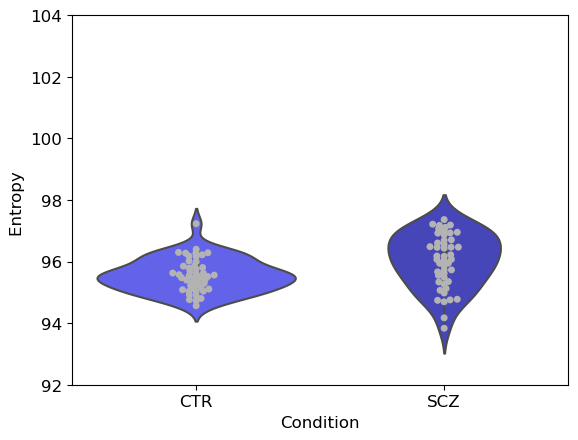

In [ ]:
#%% plots

matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

EPR_tmp = dict()
EPR_tmp['sleep stage'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
EPR_tmp['EPR'] = ENT.flatten()

EPR_df = pd.DataFrame(EPR_tmp)


# real data

plt.figure()
ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
sb.swarmplot(data=EPR_df, x='sleep stage', y='EPR', color=[0.7,0.7,0.7])
plt.axis(ymin=92, ymax=104)

plt.xlabel('Condition', fontsize=12)
plt.ylabel('Entropy ', fontsize=12)

plt.savefig(res_dir+'entropy_prod_rate.eps', format='eps')

In [ ]:
ENT

In [ ]:
import numpy as np
from scipy import stats

# Your data array
data = EPR

# Extract the two populations
population1 = data[:, 0]
population2 = data[:, 1]

# Perform two-sample t-test
t_stat, p_val = stats.ttest_ind(population1, population2)

# Print results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_val}')

T-statistic: -3.9016432093957363
P-value: 0.00018167535690136817


In [ ]:
import matplotlib.pyplot as plt

# Plot histograms of the two populations
plt.hist(population1, bins=10, alpha=0.5, label='Population 1')
plt.hist(population2, bins=10, alpha=0.5, label='Population 2')
plt.legend(loc='upper right')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Two Populations')
plt.show()

NameError: name 'population1' is not defined

In [ ]:
import pandas as pd

# Creating a pandas Series
data_fro = [0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0]
data_lim = [0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1]
data_tmp = [1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0]
data_par = [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0]
data_occ = [0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]    
    
    
index = range(68)  # Assuming the actual length is 68, but only showing a subset here

index_frot = [index for index, value in enumerate(data_fro) if value == 1]
index_fro = [x + 1 for x in index_frot]
    
index_limt = [index for index, value in enumerate(data_lim) if value == 1]
index_lim = [x + 1 for x in index_limt]

index_tmpt = [index for index, value in enumerate(data_tmp) if value == 1]
index_tmp = [x + 1 for x in index_tmpt]

index_part = [index for index, value in enumerate(data_par) if value == 1]
index_par = [x + 1 for x in index_part]

index_occt = [index for index, value in enumerate(data_occ) if value == 1]
index_occ = [x + 1 for x in index_occt]

In [ ]:
ts_ctr.shape

(68, 152, 48)

In [ ]:
data_dir = '/Users/rodrigo/Desktop/Postdoc-Codes/fMRI_FeaturesDisorders-main/' # data repo
res_dir = './' # results


graph_format = 'png' # graph formatting



conds = ['CTRL', 'SCZ']
n_cond = len(conds) # number of conditions

N = 68 # size of network for DK-68
# N = 20 # Frontal
ts_ctr = sio.loadmat(data_dir+'ts_ctr.mat')['ts_ctr']
ts_ctr=ts_ctr[:, :,20:68]
ts_scz = sio.loadmat(data_dir+'ts_scz.mat')['ts_scz']
ts_all = np.stack((ts_ctr, ts_scz), axis=-1)

ts_all.shape

# Select the components using advanced indexing
ts_ctr_fro= ts_ctr[index_fro, :, :]
ts_scz_fro= ts_scz[index_fro, :, :]
ts_fro_all = np.stack((ts_ctr_fro, ts_scz_fro), axis=-1)


# Select the components using advanced indexing
ts_ctr_occ= ts_ctr[index_occ, :, :]
ts_scz_occ= ts_scz[index_occ, :, :]
ts_occ_all = np.stack((ts_ctr_occ, ts_scz_occ), axis=-1)

# Select the components using advanced indexing
ts_ctr_tmp= ts_ctr[index_tmp, :, :]
ts_scz_tmp= ts_scz[index_tmp, :, :]
ts_tmp_all = np.stack((ts_ctr_tmp, ts_scz_tmp), axis=-1)


# Select the components using advanced indexing
ts_ctr_par= ts_ctr[index_par, :, :]
ts_scz_par= ts_scz[index_par, :, :]
ts_par_all = np.stack((ts_ctr_par, ts_scz_par), axis=-1)


# Select the components using advanced indexing
ts_ctr_lim= ts_ctr[index_lim, :, :]
ts_scz_lim= ts_scz[index_lim, :, :]
ts_lim_all = np.stack((ts_ctr_lim, ts_scz_lim), axis=-1)


In [ ]:
ts_lim_all.shape

(12, 152, 48, 2)

In [ ]:
ts_occ_all

In [ ]:

# data and model parameters
subjects = np.arange(1, 48)
n_sub = len(subjects)
N = 12

mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0
conds = ['CTR', 'SCZ']
n_cond = len(conds) # number of conditions

min_val_EC = 0. # maximal value for EC
max_val_EC = 1. # maximal value for EC
min_val_Sigma = 0. # minimal value for Sigma

# arrays to store results
var_BOLD = np.zeros([n_sub,n_cond,N]) # empirical BOLD variance
J_mod = np.zeros([n_sub,n_cond,N,N]) # model Jacobian (EC)
Sigma_mod = np.zeros([n_sub,n_cond,N,N]) # model 
FC0_mod = np.zeros([n_sub,n_cond,N,N]) # model zero-lad FC
err_mod = np.zeros([n_sub,n_cond]) # model error
fit_mod = np.zeros([n_sub,n_cond]) # model goodness of fit (Pearson corr)

#0.008-0.09 Hz
#0.008 to 0.08 Hz

n_order = 3
TR = 2 # in seconds
Nyquist_freq = 0.5 / TR # Nyquist frequency
low_f = 0.04 / Nyquist_freq # lower cutoff for bandpass filter
high_f = 0.07 / Nyquist_freq # upper cutoff for bandpass filter
b,a = spsg.iirfilter(n_order,[low_f,high_f],btype='bandpass',ftype='butter')


# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        # get time serie
        ts3=ts_lim_all[:, :,i_sub,i_cond]
        filt_ts = spsg.filtfilt(b,a,ts3,axis=1)
        ts=stats.zscore(ts3, axis=1)
        
        # store empirical BOLD variance
        var_BOLD[i_sub,i_cond,:] = ts.var(axis=1)
        
        FC0 = np.tensordot(ts[:,:-1], ts[:,:-1], axes=(1,1)) / 149
        FC1 = np.tensordot(ts[:,:-1], ts[:,1:], axes=(1,1)) / 149
        FC0N=abs(FC0)/np.max(abs(FC0))
        FC1N=abs(FC1)/np.max(abs(FC1))
        
        lim_FC0= np.percentile(FC0N, 90)
        lim_FC1= np.percentile(FC1N, 60)

        # anatomy-derived mask for existing connections for EC
        mask_EC1 = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_EC1[FC0N>lim_FC0] = True
        for i in range(N):
            mask_EC1[i,i] = False # no self connection
            
        
        mask_EC2 = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_EC2[abs(FC1N)>lim_FC1] = True
        for i in range(N):
            mask_EC2[i,i] = False # no self connection
            
        mask_EC = np.zeros([N,N],dtype=bool)
        
        mask_EC=mask_EC1 
       # mask_EC=mask_ECS
        
        # invert model
        mou_est = MOUv2()
        mou_est.fit(ts.T, mask_C=mask_EC, mask_Sigma=mask_Sigma, algo_version='true', min_iter=20, epsilon_C=0.005, epsilon_Sigma=0.005) #, verbose=True)

        # store results
        J_mod[i_sub,i_cond,:,:] = mou_est.J
        Sigma_mod[i_sub,i_cond,:,:] = mou_est.Sigma
        FC0_mod[i_sub,i_cond,:,:] = spl.solve_lyapunov(J_mod[i_sub,i_cond,:,:].T, -Sigma_mod[i_sub,i_cond,:,:])
        err_mod[i_sub,i_cond] = mou_est.d_fit['distance']
        fit_mod[i_sub,i_cond] = mou_est.d_fit['correlation']

        print('sub', i_sub, '; cond', i_cond, ':', mou_est.d_fit)

#%% save results
np.save(res_dir+'J_mod.npy',J_mod)
np.save(res_dir+'Sigma_mod.npy',Sigma_mod)
np.save(res_dir+'FC0_mod.npy',FC0_mod)

np.save(res_dir+'err_mod.npy',err_mod)
np.save(res_dir+'fit_mod.npy',fit_mod)

np.save(res_dir+'var_BOLD.npy',var_BOLD)


sub 0 ; cond 0 : {'n_tau': 2, 'iterations': 22, 'distance': 0.6887536908289305, 'correlation': 0.698018634127962, 'distance history': array([0.68875369, 0.68875369, 0.68875369, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.69801863, 0.69801863, 0.69801863, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': 0.547325800797482, 'distFC1': 0.8301815808603787}
sub 0 ; cond 1 : {'n_tau': 2, 'iterations': 635, 'distance': 0.7035206456039972, 'correlation': 0.655233981216331, 'distance history': array([0.73979201, 0.73948891, 0.73918915, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.60670158, 0.60717339, 0.60763988, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': 0.5585281539829403, 'distFC1': 0.848513156747469}
sub 1 ; cond 0 : {'n_tau': 2, 'iterations': 1235, 'distance': 0.7658063167362581, 'correlation': 0.6393748888897759, 'distance history': array([0.78783395, 0.78770255, 0.78757211, ..., 0.    

sub 11 ; cond 1 : {'n_tau': 2, 'iterations': 113, 'distance': 0.8625550489963086, 'correlation': 0.44977961610322426, 'distance history': array([0.87172634, 0.87149434, 0.87126947, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.44011977, 0.44105836, 0.44194551, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': 0.7418985383438019, 'distFC1': 0.9832212125179882}
sub 12 ; cond 0 : {'n_tau': 2, 'iterations': 773, 'distance': 0.6724213423995555, 'correlation': 0.7188022083891847, 'distance history': array([0.68721269, 0.68709456, 0.68697746, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.70258357, 0.702721  , 0.70285714, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': 0.5525042848495881, 'distFC1': 0.7923384003301279}
sub 12 ; cond 1 : {'n_tau': 2, 'iterations': 164, 'distance': 0.6864697088023619, 'correlation': 0.6324607943885178, 'distance history': array([0.69806924, 0.69773688, 0.69741648, ...

sub 22 ; cond 0 : {'n_tau': 2, 'iterations': 671, 'distance': 0.6853413950276258, 'correlation': 0.7130862429199054, 'distance history': array([0.70961085, 0.70941238, 0.70921573, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.68533014, 0.68556648, 0.68580059, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': 0.6000167113265457, 'distFC1': 0.7706660938891922}
sub 22 ; cond 1 : {'n_tau': 2, 'iterations': 655, 'distance': 0.6814465743217093, 'correlation': 0.7162218717281923, 'distance history': array([0.71895919, 0.71862143, 0.71828736, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.67082158, 0.67126263, 0.67169873, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': 0.5906480401219457, 'distFC1': 0.7722451160396329}
sub 23 ; cond 0 : {'n_tau': 2, 'iterations': 22, 'distance': 0.696782970493798, 'correlation': 0.6794434634283681, 'distance history': array([0.69678297, 0.69678297, 0.69678297, ..., 0

sub 32 ; cond 1 : {'n_tau': 2, 'iterations': 106, 'distance': 0.8039299794914461, 'correlation': 0.6434506159284117, 'distance history': array([0.81996314, 0.81941131, 0.81888481, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.5936571 , 0.5960994 , 0.59840638, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': 0.6468608695367233, 'distFC1': 0.9609992858884643}
sub 33 ; cond 0 : {'n_tau': 2, 'iterations': 1843, 'distance': 0.6221594367388019, 'correlation': 0.7566204587086911, 'distance history': array([0.64110001, 0.64103054, 0.64096135, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.73990702, 0.73996942, 0.74003156, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': 0.506761908057876, 'distFC1': 0.7375569661149955}
sub 33 ; cond 1 : {'n_tau': 2, 'iterations': 7176, 'distance': 0.7264565511088688, 'correlation': 0.6458276504030536, 'distance history': array([0.73643161, 0.73638935, 0.73634729, ...

sub 42 ; cond 1 : {'n_tau': 2, 'iterations': 200, 'distance': 0.7921352843115634, 'correlation': 0.6156269347521992, 'distance history': array([0.81369407, 0.81327866, 0.81287486, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.59374695, 0.59502954, 0.59625442, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': 0.6322514539795383, 'distFC1': 0.952037383066988}
sub 43 ; cond 0 : {'n_tau': 2, 'iterations': 396, 'distance': 0.6494768301814822, 'correlation': 0.7347615357604559, 'distance history': array([0.69968515, 0.69927659, 0.6988719 , ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.68276706, 0.68323738, 0.68370297, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': 0.5633413317028726, 'distFC1': 0.7356129197884917}
sub 43 ; cond 1 : {'n_tau': 2, 'iterations': 671, 'distance': 0.6352973212390493, 'correlation': 0.7221882627244715, 'distance history': array([0.66990107, 0.66958596, 0.66927441, ..., 

In [ ]:
# transpose to Saclay's framework
EPR = np.zeros([n_sub,n_cond])
Q_indiv = np.zeros([n_sub,n_cond,N,N])

for i_sub in range(n_sub):
    for i_cond in range(n_cond):

        try:
            B = np.copy(-J_mod[i_sub,i_cond,:,:].T)
            D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:])
            S = np.copy(FC0_mod[i_sub,i_cond,:,:])
            
            Q = np.dot(B, S) - D
            Q_indiv[i_sub,i_cond,:,:] = Q
            
            # sanity check
            if True:
                print('should be close to zero:', np.abs(np.dot(B,S) + np.dot(S,B.T) -2*D).max())
            
            # formula from Godreche Luck
            Dinv = np.linalg.pinv(D)
            Sinv = np.linalg.pinv(S)
            
            entropy_prod_rate = -np.trace(np.dot(np.dot(np.dot(Sinv, Q), Dinv), Q))
            EPR[i_sub,i_cond] = entropy_prod_rate

        except:
            print('problem with subject/cond:', i_sub, i_cond)
       

np.save(res_dir+'EPR.npy',EPR)



should be close to zero: 0.0
should be close to zero: 4.440892098500626e-16
should be close to zero: 1.700029006457271e-16
should be close to zero: 0.0
should be close to zero: 8.881784197001252e-16
should be close to zero: 6.661338147750939e-16
should be close to zero: 0.0
should be close to zero: 6.661338147750939e-16
should be close to zero: 1.7763568394002505e-15
should be close to zero: 3.0531133177191805e-16
should be close to zero: 4.440892098500626e-16
should be close to zero: 5.342948306008566e-16
should be close to zero: 2.220446049250313e-16
should be close to zero: 6.661338147750939e-16
should be close to zero: 0.0
should be close to zero: 0.0
should be close to zero: 6.661338147750939e-16
should be close to zero: 3.552713678800501e-15
should be close to zero: 3.0531133177191805e-16
should be close to zero: 2.220446049250313e-16
should be close to zero: 4.440892098500626e-16
should be close to zero: 0.0
should be close to zero: 0.0
should be close to zero: 3.552713678800501

/Users/rodrigo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


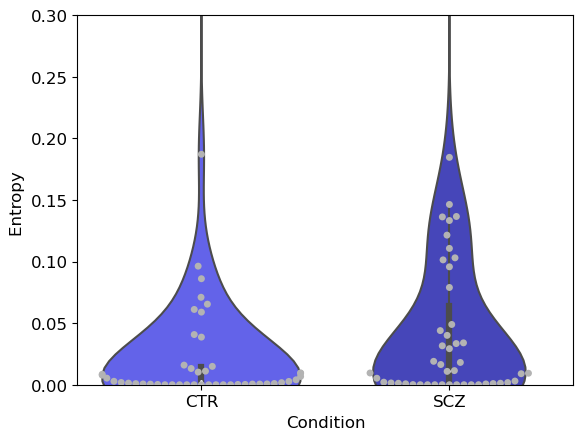

In [ ]:
#%% plots

matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

EPR_tmp = dict()
EPR_tmp['sleep stage'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
EPR_tmp['EPR'] = EPR.flatten()

EPR_df = pd.DataFrame(EPR_tmp)


# real data

plt.figure()
ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
sb.swarmplot(data=EPR_df, x='sleep stage', y='EPR', color=[0.7,0.7,0.7])
plt.axis(ymin=0, ymax=0.3)

plt.xlabel('Condition', fontsize=12)
plt.ylabel('Entropy ', fontsize=12)

plt.savefig(res_dir+'entropy_prod_rate.eps', format='eps')

In [ ]:
EPR_df

,sleep stage,EPR
0,CTR,-0.000000
1,SCZ,0.078942
2,CTR,0.000904
3,SCZ,0.184554
4,CTR,0.003993
...,...,...
89,SCZ,0.001225
90,CTR,0.038650
91,SCZ,0.001448
92,CTR,0.414697
